# Plot Orbital Trajectories from Spice Kernels 

In [1]:
import heliopy.data.spice as spicedata
import heliopy.spice as spice

from datetime import datetime,timedelta

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import animation, rc
from IPython.display import HTML

import astropy.constants as const
import astropy.units as u
from glob import glob
from ntpath import basename
import numpy as np
from urllib.request import urlretrieve
import os 

rc('animation',html='html5')

# heliopy, sunpy, cdflib, spiceypy non -standard dependencies

### Get Available Spice Kernels from Heliopy

In [2]:
for kernel in spicedata.kernel_dict : # Do Downloads to Local Machine, furnsh to spice:
    if kernel != "soho":
        k = spicedata.get_kernel(kernel)
        for kernel_path in k :
            try : spice.furnish(kernel_path)
            except : print(f"Kernel {basename(kernel_path)} was not downloaded, not furnished")
        print(kernel)

lsk
planet_trajectories
planet_orientations
helio_frames
cassini
helios1
helios2
juno
stereo_a
stereo_b
ulysses
psp
solo
psp_pred
stereo_a_pred


100.0% 983040 / 975872
  0.0%      0 / 975872

100.0% 983040 / 975872


stereo_b_pred
juno_pred
bepi_pred


### Download some more kernels from NAIF

In [3]:
spicedata.spice_dir

'/home/sbadman/heliopy/data/spice'

In [4]:
extra_spice_dict = {
    "VOYAGER 1" : 'https://naif.jpl.nasa.gov/pub/naif/VOYAGER/kernels/spk/Voyager_1.a54206u_V0.2_merged.bsp',
    "VOYAGER 2" : 'https://naif.jpl.nasa.gov/pub/naif/VOYAGER/kernels/spk/Voyager_2.m05016u.merged.bsp',   
    "STEREO B 2007a" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2007_021_01.depm.bsp",
    "STEREO B 2007b" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2007_053_01.depm.bsp",
    "STEREO B 2008a" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2008_037_01.depm.bsp",
    "STEREO B 2008b" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2008_078_01.depm.bsp",
    "STEREO B 2010"  : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2010_203_01.depm.bsp",
    "STEREO B 2011"  : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2011_193_01.depm.bsp",
    "STEREO B 2012"  : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2012_265_01.depm.bsp",
    "STEREO B 2014a" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2014_002_01.depm.bsp",
    "STEREO B 2014b" : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2014_271_01.depm.bsp",
    "STEREO B 2016"  : "https://sohowww.nascom.nasa.gov/solarsoft/stereo/gen/data/spice/depm/behind/behind_2016_256_01.depm.bsp",
}
for entry in extra_spice_dict :
    url = extra_spice_dict.get(entry)
    local = spicedata.data_dir+"/spice/"+basename(url)
    try :
        if not os.path.isfile(local) : 
            print(f"Downloaded {basename(url)}")
            path=urlretrieve(url,local)
        k = spice.SPKKernel(local)
        spice.furnish(k)
        print(entry)
    except Exception as e : print(e)

VOYAGER 1
VOYAGER 2
STEREO B 2007a
STEREO B 2007b
STEREO B 2008a
STEREO B 2008b
STEREO B 2010
STEREO B 2011
STEREO B 2012
STEREO B 2014a
STEREO B 2014b
STEREO B 2016


In [6]:
spice.Trajectory("Earth").target.name

'Earth'

In [3]:
def orbital_animations(body_list,t_start,t_final,t_delta=1.0,
                       SPICE_Origin='SUN',SPICE_Frame='ECLIPJ2000',
                       units='au',fname=None,fps=60,
                       ecliptic_proj=False,
                       edge_on=False
                      ):
    '''
    Parameters
    ----------
    body_list : tuple containing strings of bodies for which spice data exists, e.g. ['Earth']
    t_start : start day for animation, format Tuple(YYYY,MM,DD)
    t_final : end day for animation, format Tuple(YYYY,MM,DD)
    
    
    Keywords
    --------
    t_delta=1.0 : time cadence of each frame in animation, format float number of days, default : 1.0
    SPICE_Origin='SUN' : string containing origin defined in SPICE
    SPICE_Frame='ECLIPJ2000' : string containing frame defined in SPICE
    units='au' : string corresponding to unit for plotting,alt : 'm','R_earth','R_sun'
    fname=None : output filename, defaults to orbit.mp4
    '''
    # Generate Heliopy Spice Body Objects
    bodies = [spice.Trajectory(body) for body in body_list]

    # Generate Time Series to Plot Orbits Over
    starttime = datetime(*t_start) 
    endtime = datetime(*t_final) 
    times = []
    while starttime < endtime:
        times.append(starttime)
        starttime += timedelta(days=t_delta)

    unit_dict = {'m' : u.m, 'R_earth' : u.R_earth, 'R_sun' : u.R_sun, 'au' : u.au}    
        
    # Generate Positions for each body over the specified times
    reference = SPICE_Origin
    frame = SPICE_Frame
    spice_error_inds = [] 
    for body,index in zip(bodies,range(len(bodies))) :
        try : # If no or partial spice data for a given body in the timeframe, remove from plot
            body.generate_positions(times, reference, frame)
            body.change_units(unit_dict.get(units))
        except :
            print(f"Some/All SPICE data missing for {body.target.name} in time range {t_start} to {t_final}")
            print(f"Omitting {body.target}")
            spice_error_inds.append(index-len(spice_error_inds))
    if len(spice_error_inds) > 0 :
        for ind in spice_error_inds : bodies.pop(ind)        
        print(f"Remaining bodies in list : {[body_.target for body_ in bodies]}")
    
    maxes = []
    for body in bodies : 
        maxes.append(np.max(np.abs(body.x.value)))
        maxes.append(np.max(np.abs(body.y.value)))
        maxes.append(np.max(np.abs(body.z.value)))
    maximum = np.max(maxes)

    
    # Setup Figure
    fig,ax = plt.subplots(figsize=(15,15),subplot_kw={'projection' :'3d'})
    ax.set_xlim([-maximum,maximum])
    ax.set_ylim([-maximum,maximum])
    ax.set_zlim([-maximum,maximum])
    ax.set_xlabel(f"X-ECLIPJ2000 [{units}]",fontsize=17)
    ax.set_ylabel(f"Y-ECLIPJ2000 [{units}]",fontsize=17)
    ax.set_zlabel(f"Z-ECLIPJ2000 [{units}]",fontsize=17)
    full_trajs,recent_trajs = [],[]
    for body in bodies :
        full_trajs.append(ax.plot([],[],[],lw=0.5)[0])
        recent_trajs.append(ax.plot([],[],[],lw=4,label=body.target.name,color=full_trajs[-1].get_c())[0])
    current_locs = [ax.scatter([],[],[],color="black")]
    texts = [ax.text(-maximum,-maximum,maximum,"",fontsize=20)]
    legend = plt.legend(fontsize=17)
    if ecliptic_proj : 
        ax.view_init(90,-90)
    if edge_on : 
        ax.view_init(0,-90)
    
    # Initialize Figure
    def init():
        xi,yi,zi = [],[],[]
        for full_traj,recent_traj,body in zip(full_trajs,recent_trajs,bodies) :
            full_traj.set_data(np.array([]),
                               np.array([])
                              )
            full_traj.set_3d_properties([])
            recent_traj.set_data(np.array([]),
                                 np.array([])
                                )
            recent_traj.set_3d_properties([])
            xi.append(body.x.value[0])
            yi.append(body.y.value[0])
            zi.append(body.z.value[0])
        current_locs[0]._offsets3d = np.array([xi,yi,zi])
        texts[0].set_text(f"{times[0]}")
        return full_trajs+recent_trajs+current_locs+texts
    
    # Animation Update #10 days most recent positions
    def animate(i):
        xi,yi,zi=[],[],[]
        for full_traj,recent_traj,body in zip(full_trajs,recent_trajs,bodies) :
            full_traj.set_data(body.x.value[:i],body.y.value[:i])
            full_traj.set_3d_properties(body.z.value[:i])
            recent_traj.set_data(body.x.value[i-20:i],body.y.value[i-20:i])
            recent_traj.set_3d_properties(body.z.value[i-20:i])
            xi.append(body.x.value[i])
            yi.append(body.y.value[i])
            zi.append(body.z.value[i])
        current_locs[0]._offsets3d = np.array([xi,yi,zi])
        texts[0].set_text(f"{times[i]}")
        return recent_trajs+current_locs+texts

    anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(times)-1,blit=True)
    if fname is not None : anim.save(fname,fps=fps)
    else : anim.save('orbits.mp4',fps=fps)

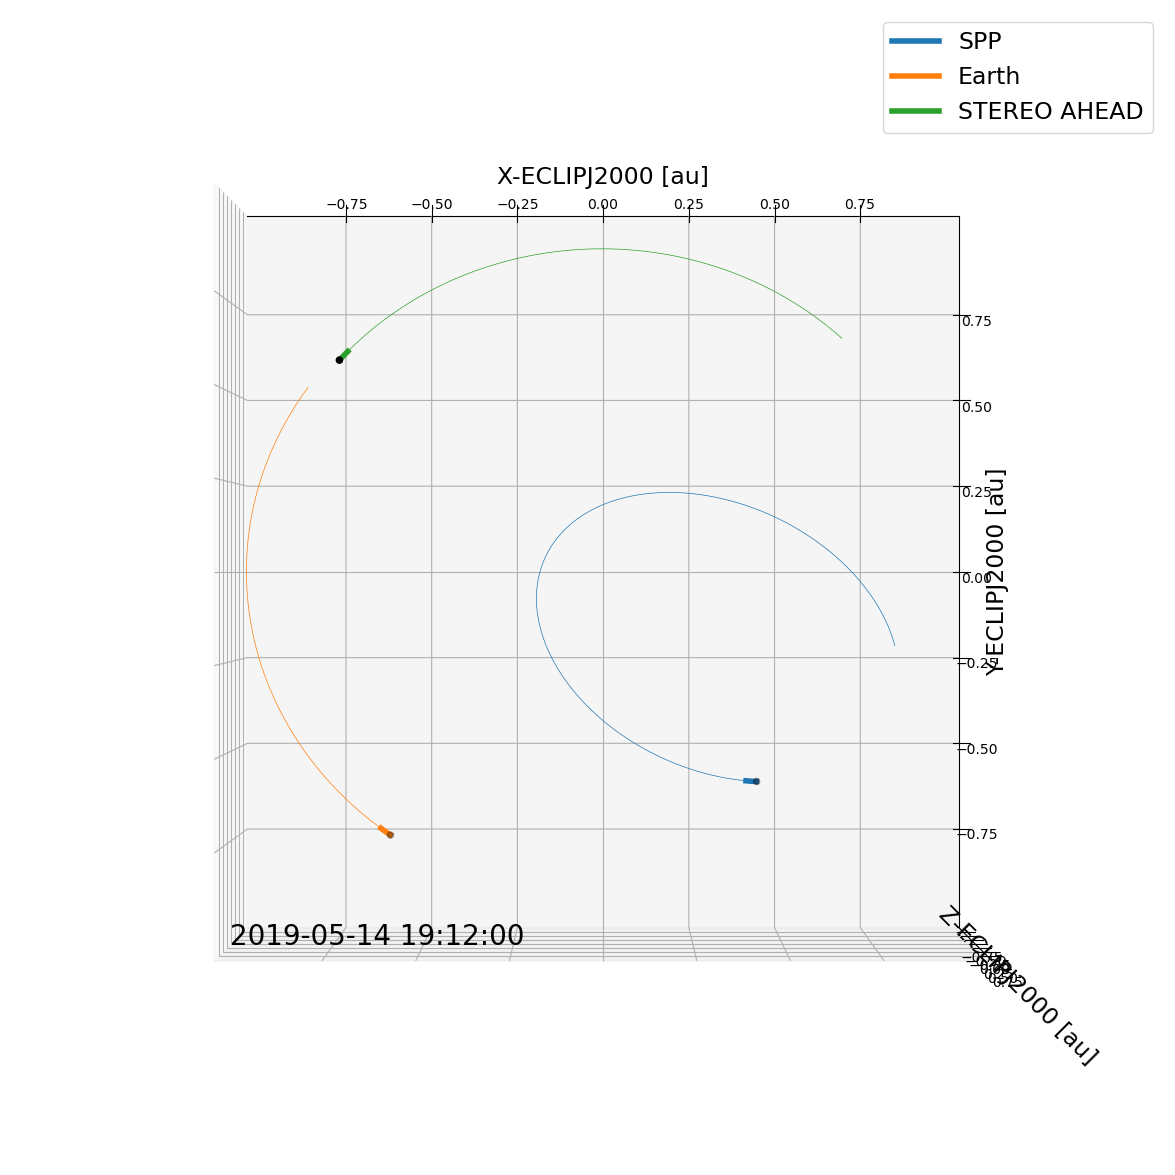

In [7]:
body_list = ['SPP',
             'Earth',
             'STEREO AHEAD',
             #'Mars_barycenter',
             #'Venus_barycenter',
            ]
start = (2019, 2, 15)
end = (2019, 5, 15)

## Note to use .mp4 file extension must have ffmpeg installed on system
## if not, change .mp4 to .gif and code will use Pillow (internal to python)
orbital_animations(body_list,start,end,
                   SPICE_Frame="J2000",
                   fname='psp_e4.mp4',t_delta=0.1,ecliptic_proj=True)

## Ulysses 1991 Jupiter Gravity Assist

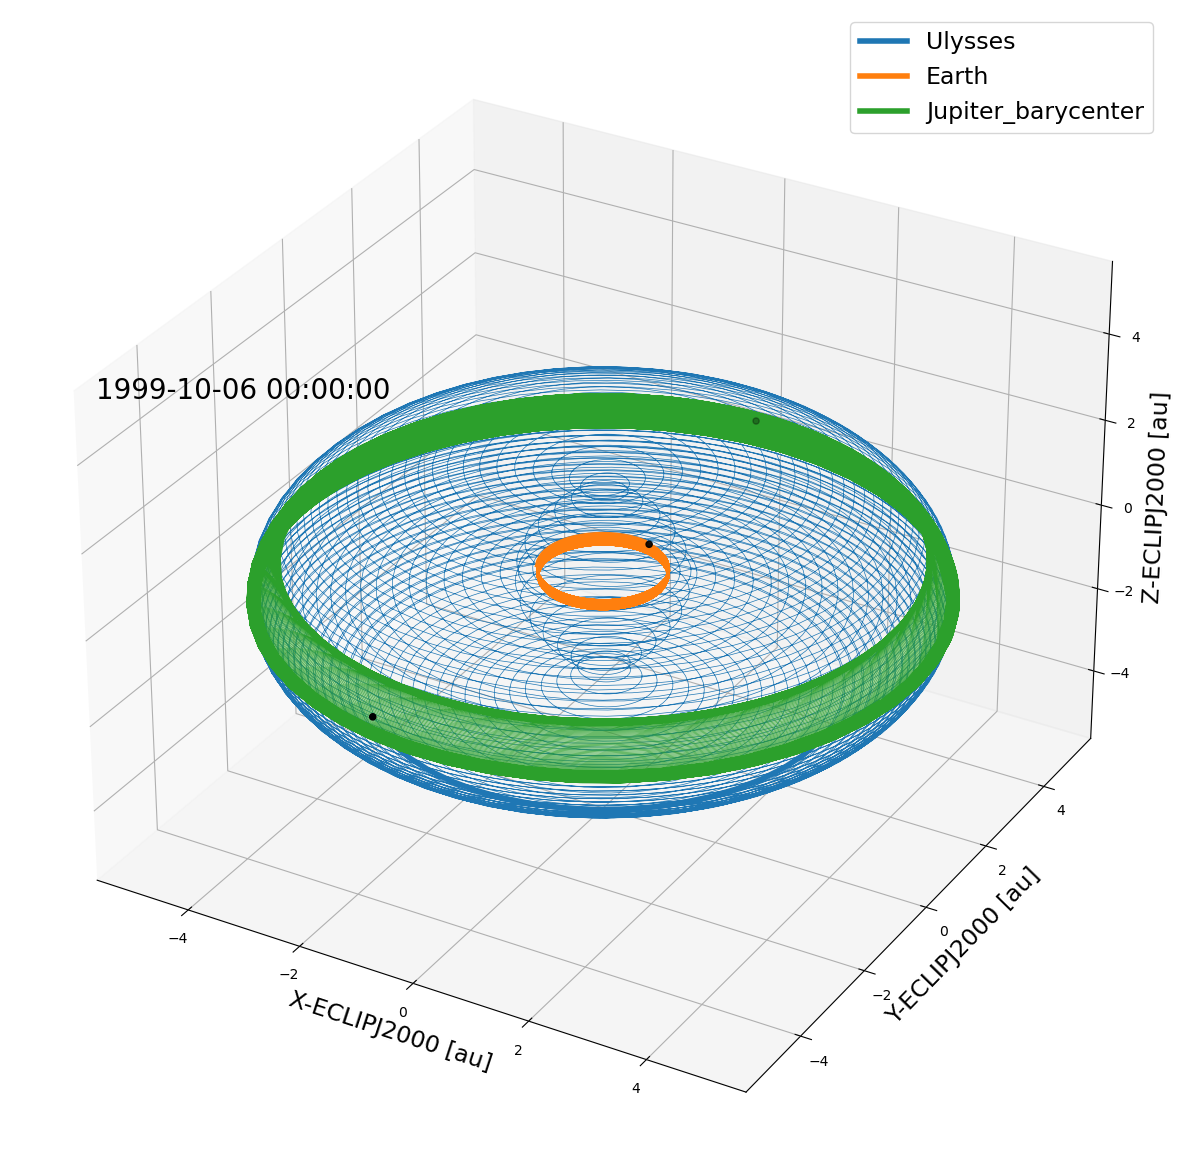

In [7]:
body_list = ['Ulysses',
             'Earth',
             'Jupiter_barycenter',
             #'Mars_barycenter',
             #'Venus_barycenter',
            ]
start = (1990, 10, 7)
end = (1999, 10, 7)

## Note to use .mp4 file extension must have ffmpeg installed on system
## if not, change .mp4 to .gif and code will use Pillow (internal to python)
orbital_animations(body_list,start,end,
                   SPICE_Frame="IAU_Sun",
                   fname='ulysses_carr.mp4',t_delta=0.5)

## Helios 1 and  2 1976-1979

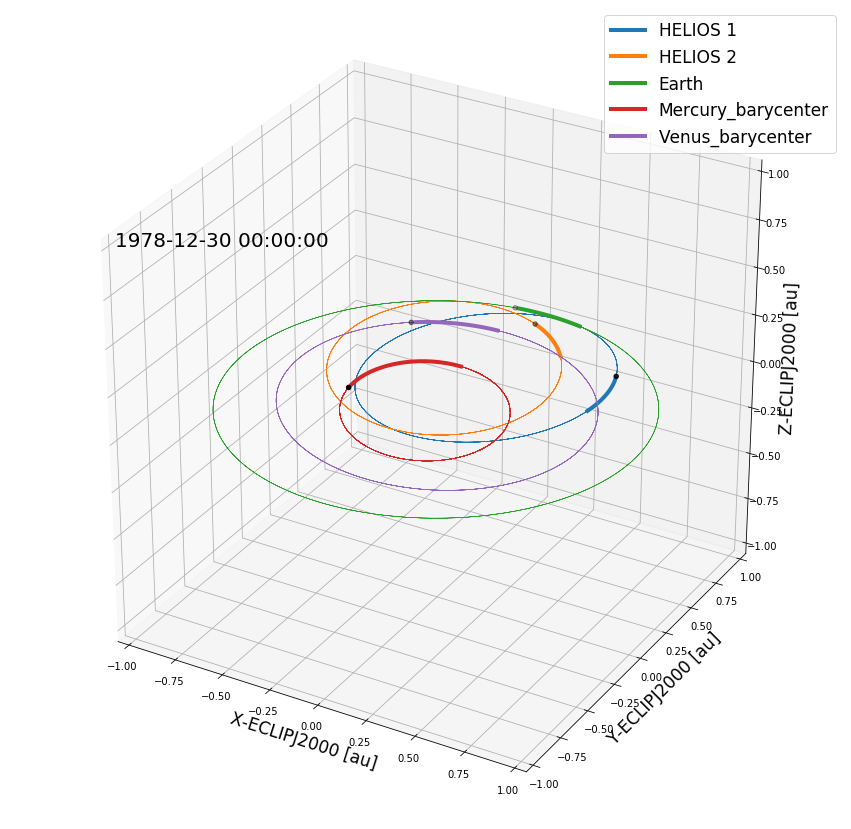

In [6]:
body_list = ['HELIOS 1',
             'HELIOS 2',
             'Earth',
             'Mercury_barycenter',
             'Venus_barycenter',
            ]
start=(1976, 1, 16) 
end=(1979, 1, 1)
orbital_animations(body_list,start,end,fname='helios.mp4')

## Parker Solar Probe

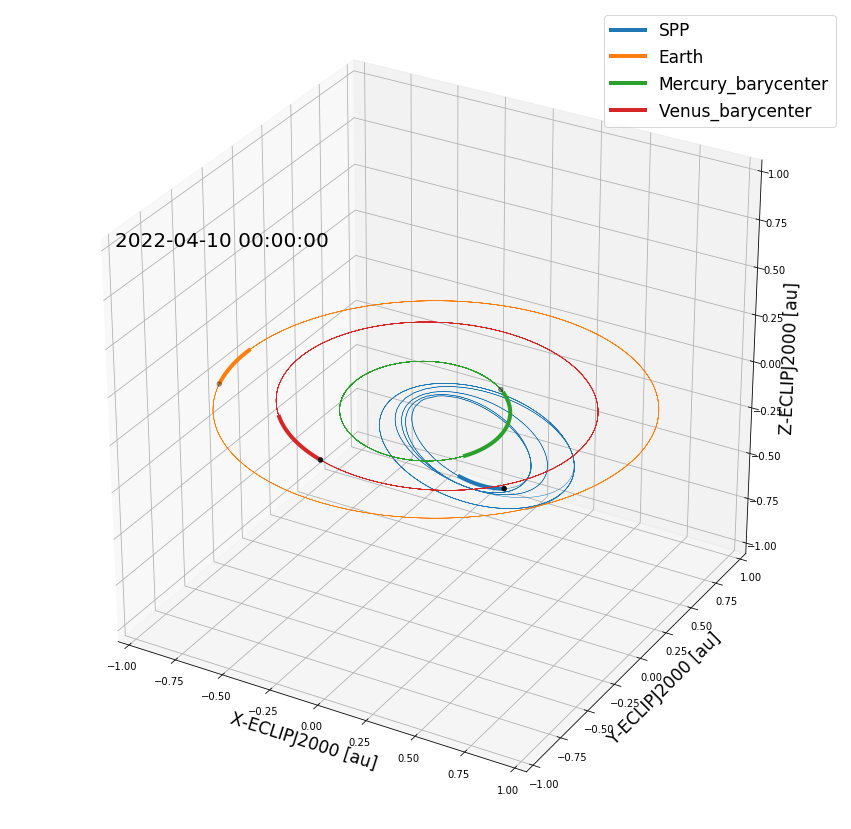

In [7]:
body_list = ['SPP',
             'Earth',
             'Mercury_barycenter',
             'Venus_barycenter',
            ]
start=(2018, 8, 17) 
end=(2022, 4, 12)
orbital_animations(body_list,start,end,fname='psp.mp4',fps=30)

## Juno 
### Part 2 : Polar Orbit Since July 2016

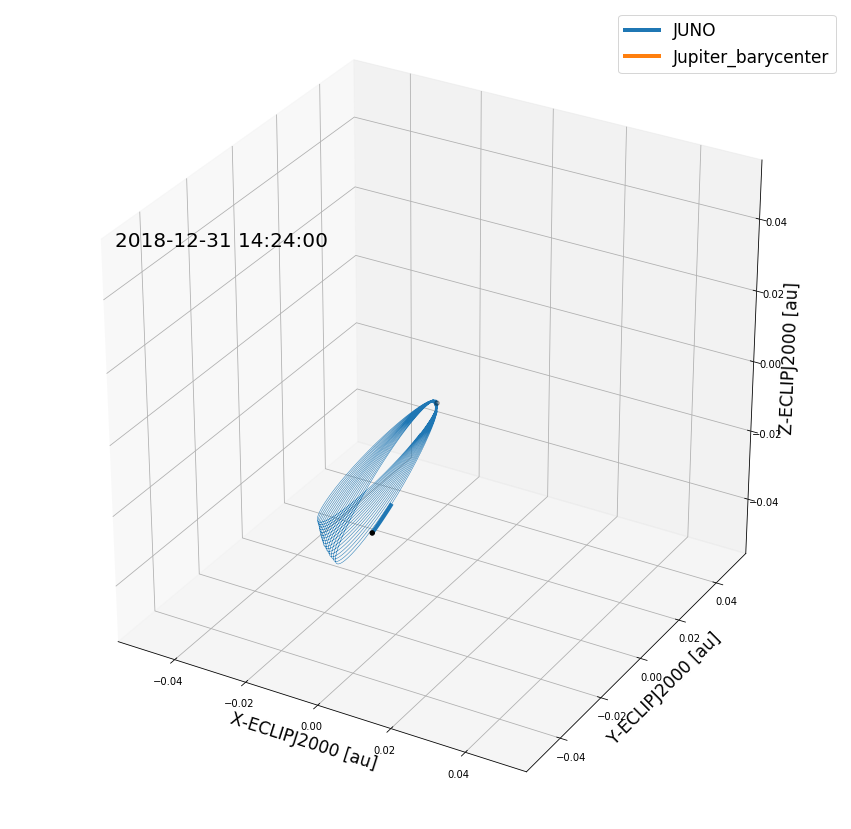

In [8]:
body_list = ['JUNO',
             'Jupiter_barycenter',
            ]
start=(2016, 7, 6) 
end=(2019, 1, 1)
orbital_animations(body_list,start,end,fname='juno.mp4',fps=30,SPICE_Origin='Jupiter_barycenter',
                  t_delta=0.2)

### STEREO A and B

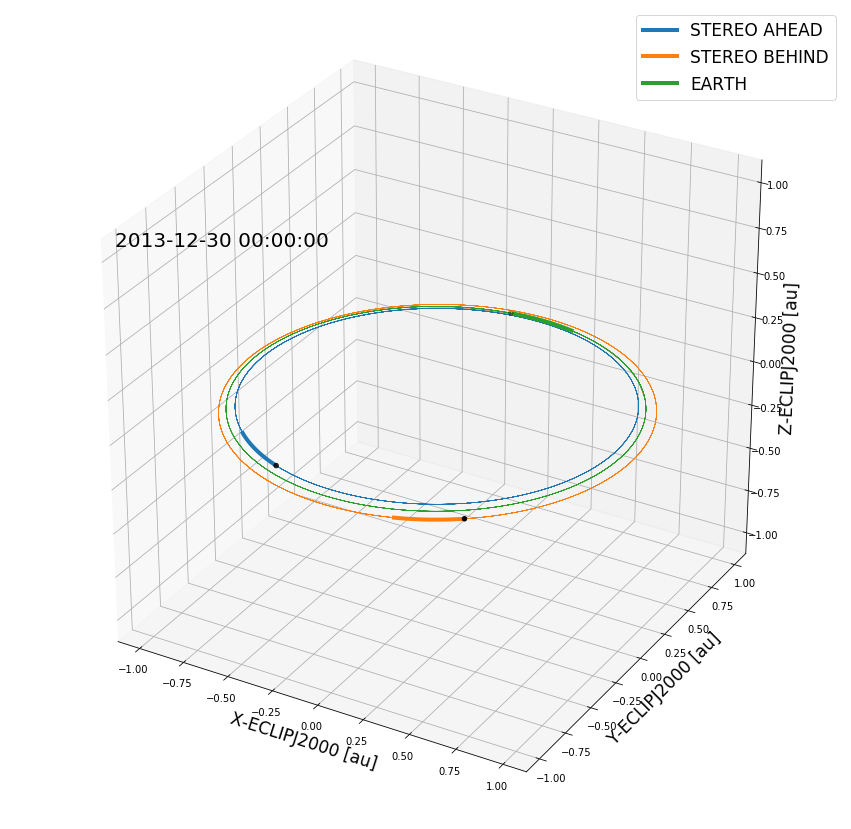

In [9]:
body_list = ['STEREO AHEAD',
             'STEREO BEHIND',
             'EARTH'
            ]
start=(2006, 10, 27) 
end=(2014, 1, 1)
orbital_animations(body_list,start,end,fname='stereo.mp4',
                   fps=30,
                   t_delta=1.0
                  )

### Solar Orbiter

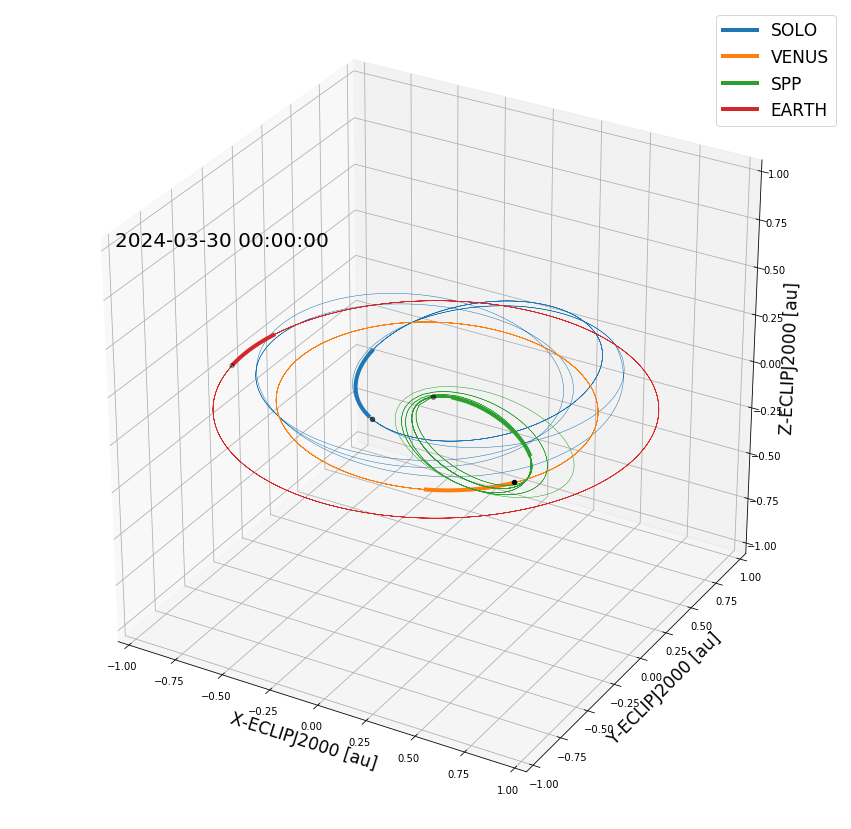

In [10]:
body_list = ['SOLO',
             'VENUS',
             'SPP',
             'EARTH',
            ]
start=(2020, 3, 1) 
end=(2024, 4, 1)
orbital_animations(body_list,start,end,fname='solar-orbiter.mp4',
                   fps=30,
                   t_delta=1.0
                  )

### Voyagers

### Voyager 1 and 2

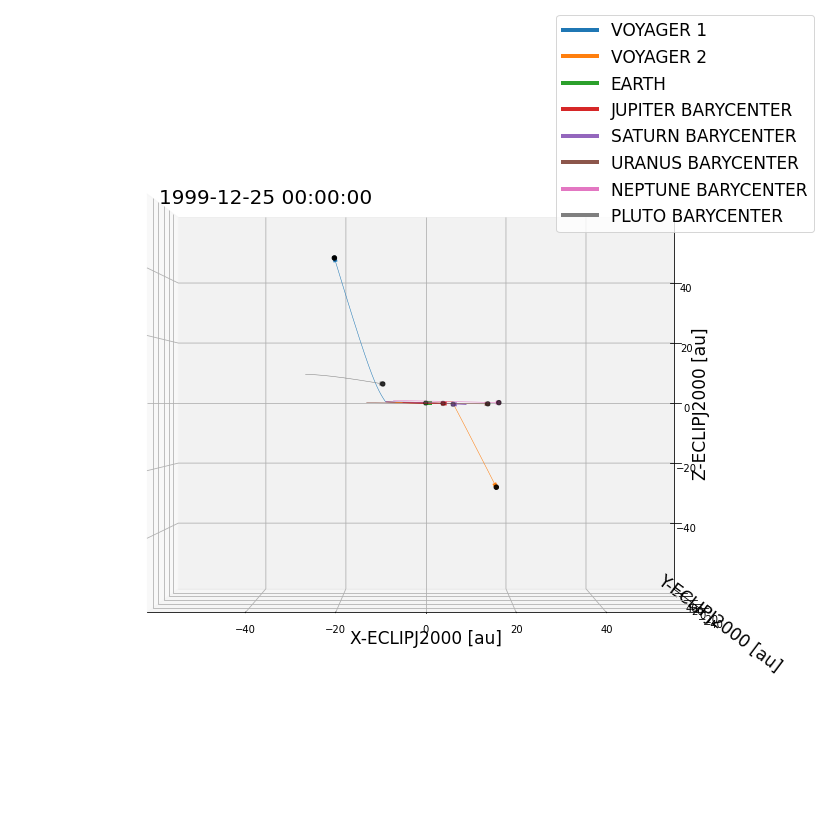

In [9]:
body_list = ['VOYAGER 1',
             'VOYAGER 2',
             'EARTH',
             'JUPITER BARYCENTER',
             'SATURN BARYCENTER',
             'URANUS BARYCENTER',
             'NEPTUNE BARYCENTER',
             'PLUTO BARYCENTER'
            ]
start=(1977, 10, 1) 
end=(2000, 1, 1)
orbital_animations(body_list,start,end,fname='vgr1&2_eo.mp4',
                   fps=60,
                   t_delta=5.0,
                   edge_on=True
                  )

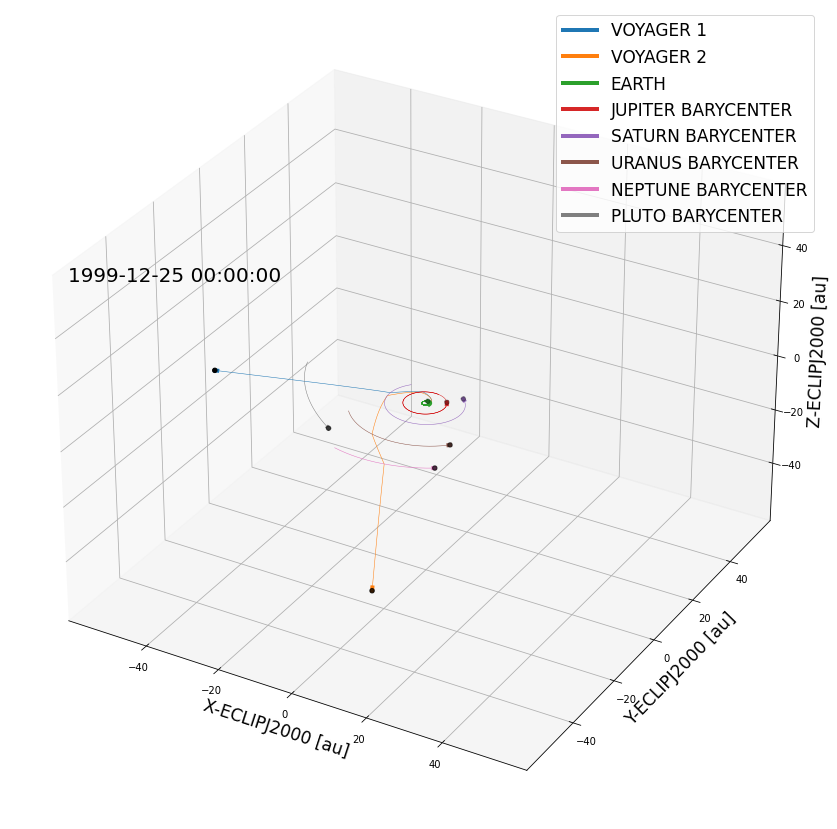

In [6]:
body_list = ['VOYAGER 1',
             'VOYAGER 2',
             'EARTH',
             'JUPITER BARYCENTER',
             'SATURN BARYCENTER',
             'URANUS BARYCENTER',
             'NEPTUNE BARYCENTER',
             'PLUTO BARYCENTER'
            ]
start=(1977, 10, 1) 
end=(2000, 1, 1)
orbital_animations(body_list,start,end,fname='vgr1&2.mp4',
                   fps=60,
                   t_delta=5.0
                  )

### PSP Perihelion 2 

In [13]:
body_list = ['SPP',
             'Earth',
             'STEREO AHEAD',
            ]
spice.spiceypy.furnsh('/media/samuel_badman/ExtraDrive1/spice_kernels/pystereo.tm')
start=(2019, 3, 1) 
end=(2019, 4, 30)
orbital_animations(body_list,start,end,fname='psp_E2.mp4',fps=30,SPICE_Frame='HEE',
                  ecliptic_proj=True,t_delta = 0.25)

SpiceyError: 
================================================================================

Toolkit version: N0066

SPICE(NOSUCHFILE) --

The attempt to load "/media/samuel_badman/ExtraDrive1/spice_kernels/pystereo.tm" by the routine FURNSH failed. It could not be located.

furnsh_c --> FURNSH --> ZZLDKER

================================================================================

### Wind-STEREO Constellation

In [61]:
SPICE_Origin = 'Sun'
SPICE_Frame = 'HEE'#'ECLIPJ2000'
t_start=(2006, 10, 27) 
t_final=(2014, 1, 1)
t_delta=1
units = 'au'
body_list = ['STEREO AHEAD','STEREO BEHIND', 'Earth']
# Generate Heliopy Spice Body Objects
bodies = [spice.Trajectory(body) for body in body_list]

# Generate Time Series to Plot Orbits Over
starttime = datetime(*t_start) 
endtime = datetime(*t_final) 
times = []
while starttime < endtime:
    times.append(starttime)
    starttime += timedelta(days=t_delta)

unit_dict = {'m' : u.m, 'R_earth' : u.R_earth, 'R_sun' : u.R_sun, 'au' : u.au}    

# Generate Positions for each body over the specified times
reference = SPICE_Origin
frame = SPICE_Frame
spice_error_inds = [] 
for body,index in zip(bodies,range(len(bodies))) :
    try : # If no or partial spice data for a given body in the timeframe, remove from plot
        body.generate_positions(times, reference, frame)
        body.change_units(unit_dict.get(units))
    except :
        print(f"Some/All SPICE data missing for {body.target} in time range {t_start} to {t_final}")
        print(f"Omitting {body.target}")
        spice_error_inds.append(index-len(spice_error_inds))
if len(spice_error_inds) > 0 :
    for ind in spice_error_inds : bodies.pop(ind)        
    print(f"Remaining bodies in list : {[body_.target for body_ in bodies]}")
    

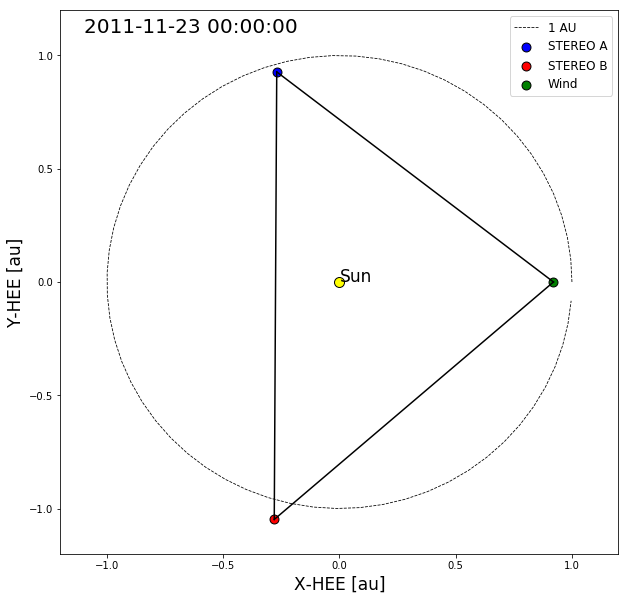

In [70]:
L_mult = 1- ((const.M_earth.value/(const.M_earth.value+const.M_sun.value))/3)**(1/3) # L1 point ratio

Ax,Bx,Wx = [body.x.value for body in bodies]
Ay,By,Wy = [body.y.value for body in bodies]
Wx *= L_mult
Wy *= L_mult

# Setup Figure
fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_xlabel(f"X-{SPICE_Frame} [{units}]",fontsize=17)
ax.set_ylabel(f"Y-{SPICE_Frame} [{units}]",fontsize=17)

sol = ax.scatter(0,0,marker='o',color="yellow",s=100,edgecolors='black')
sol_txt = plt.text(0,0,"Sun",fontsize=17)

AB = ax.plot([Ax[0],Bx[0]],[Ay[0],By[0]],color="black")[0]
AW = ax.plot([Ax[0],Wx[0]],[Ay[0],Wy[0]],color="black")[0]
BW = ax.plot([Bx[0],Wx[0]],[By[0],Wy[0]],color="black")[0]

#A_orb = ax.plot(Ax,Ay,linestyle = ":",color="black",alpha=0.5,linewidth=0.5)
#B_orb = ax.plot(Bx,By,linestyle = ":",color="black",alpha=0.5,linewidth=0.5)
#W_orb = ax.plot(Wx,Wy,linestyle = ":",color="black",alpha=0.5,linewidth=0.5)
angle=np.arange(0,2*np.pi,0.1)
ONE_AU = ax.plot(np.cos(angle),np.sin(angle),color="black",linewidth=0.8,linestyle="--",label="1 AU")

A = ax.scatter(Ax[0],Ay[0],color="blue",s=80,label="STEREO A",edgecolors='black')
B = ax.scatter(Bx[0],By[0],color="red",s=80,label="STEREO B",edgecolors='black')
W = ax.scatter(Wx[0],Wy[0],color="green",s=80,label="Wind",edgecolors='black')

texts = [ax.text(-1.1,1.1,f"{times[0]}",fontsize=20)]

legend = plt.legend(fontsize=12,loc=1)


def plot_constellation(ii) :
    AB.set_data([Ax[ii],Bx[ii]],[Ay[ii],By[ii]])
    AW.set_data([Ax[ii],Wx[ii]],[Ay[ii],Wy[ii]])
    BW.set_data([Bx[ii],Wx[ii]],[By[ii],Wy[ii]])
    A.set_offsets([Ax[ii],Ay[ii]])
    B.set_offsets([Bx[ii],By[ii]])
    W.set_offsets([Wx[ii],Wy[ii]])
    texts[0].set_text(f"{times[ii]}")
    return [AB,AW,BW,A,B,W]

date_time = datetime(2011,11,23)
ii = np.where(np.array(times) >= date_time)[0][0]
AB,AW,BW,A,B,W=plot_constellation(ii)

In [69]:
fname="AWB_Constellation_HEE.mp4"
fps = 24
anim = animation.FuncAnimation(fig,plot_constellation,frames=len(times)-1,blit=True)
anim.save(fname,fps=fps)

### Wind-STEREO-PSP-SO Constellation

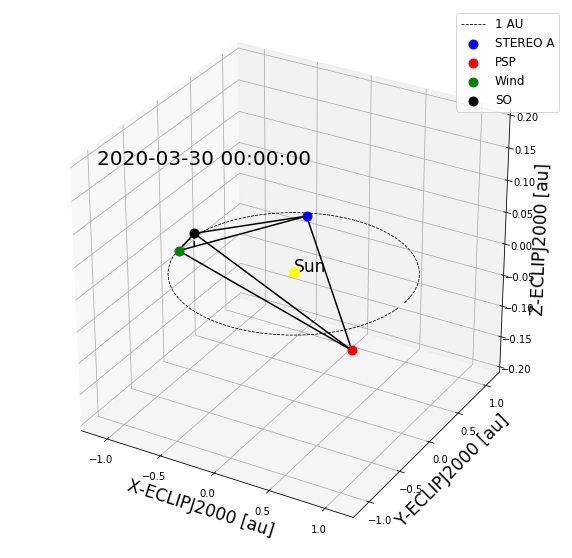

In [13]:
SPICE_Origin = 'Sun'
SPICE_Frame = 'ECLIPJ2000'
t_start=(2020, 3, 1) 
t_final=(2024, 3, 1)
t_delta=1
units = 'au'
body_list = ['STEREO AHEAD', 'Earth','SPP','SOLO']
# Generate Heliopy Spice Body Objects
bodies = [spice.Trajectory(body) for body in body_list]

# Generate Time Series to Plot Orbits Over
starttime = datetime(*t_start) 
endtime = datetime(*t_final) 
times = []
while starttime < endtime:
    times.append(starttime)
    starttime += timedelta(days=t_delta)

unit_dict = {'m' : u.m, 'R_earth' : u.R_earth, 'R_sun' : u.R_sun, 'au' : u.au}    

# Generate Positions for each body over the specified times
reference = SPICE_Origin
frame = SPICE_Frame
spice_error_inds = [] 
for body,index in zip(bodies,range(len(bodies))) :
    try : # If no or partial spice data for a given body in the timeframe, remove from plot
        body.generate_positions(times, reference, frame)
        body.change_units(unit_dict.get(units))
    except :
        print(f"Some/All SPICE data missing for {body.target} in time range {t_start} to {t_final}")
        print(f"Omitting {body.target}")
        spice_error_inds.append(index-len(spice_error_inds))
if len(spice_error_inds) > 0 :
    for ind in spice_error_inds : bodies.pop(ind)        
    print(f"Remaining bodies in list : {[body_.target for body_ in bodies]}")
    
    
L_mult = 1- ((const.M_earth.value/(const.M_earth.value+const.M_sun.value))/3)**(1/3) # L1 point ratio

Ax,Wx,Px,Sx = [body.x.value for body in bodies]
Ay,Wy,Py,Sy = [body.y.value for body in bodies]
Az,Wz,Pz,Sz = [body.z.value for body in bodies]
Wx *= L_mult
Wy *= L_mult

# Setup Figure
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection' :'3d'})
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_zlim([-0.2,0.2])
ax.set_xlabel(f"X-{SPICE_Frame} [{units}]",fontsize=17)
ax.set_ylabel(f"Y-{SPICE_Frame} [{units}]",fontsize=17)
ax.set_zlabel(f"Z-{SPICE_Frame} [{units}]",fontsize=17)

sol = ax.scatter(0,0,0,marker='o',color="yellow",s=100)
sol_txt = ax.text(0,0,0,"Sun",fontsize=17)

AW = ax.plot([Ax[0],Wx[0]],[Ay[0],Wy[0]],[Az[0],Wz[0]],color="black")[0]
AP = ax.plot([Ax[0],Px[0]],[Ay[0],Py[0]],[Az[0],Pz[0]],color="black")[0]
AS = ax.plot([Ax[0],Sx[0]],[Ay[0],Sy[0]],[Az[0],Sz[0]],color="black")[0]
WP = ax.plot([Wx[0],Px[0]],[Wy[0],Py[0]],[Wz[0],Pz[0]],color="black")[0]
WS = ax.plot([Wx[0],Sx[0]],[Wy[0],Sy[0]],[Wz[0],Sz[0]],color="black")[0]
PS = ax.plot([Px[0],Sx[0]],[Py[0],Sy[0]],[Pz[0],Sz[0]],color="black")[0]

#A_orb = ax.plot(Ax,Ay,linestyle = ":",color="black",alpha=0.5,linewidth=0.5)
#B_orb = ax.plot(Bx,By,linestyle = ":",color="black",alpha=0.5,linewidth=0.5)
#W_orb = ax.plot(Wx,Wy,linestyle = ":",color="black",alpha=0.5,linewidth=0.5)
angle=np.arange(0,2*np.pi,0.1)
ONE_AU = ax.plot(np.cos(angle),np.sin(angle),color="black",linewidth=0.8,linestyle="--",label="1 AU")

A = ax.scatter(Ax[0],Ay[0],color="blue",s=80,label="STEREO A")
P = ax.scatter(Px[0],Py[0],color="red",s=80,label="PSP")
W = ax.scatter(Wx[0],Wy[0],color="green",s=80,label="Wind")
S = ax.scatter(Sx[0],Sy[0],color="black",s=80,label="SO")
S_height = ax.plot([Sx[0],Sx[0]],[Sy[0],Sy[0]],[0.,Sz[0]],color="black",linestyle="--")[0]
texts = [ax.text(-1.1,-1.1,0.2,f"{times[0]}",fontsize=20)]

legend = plt.legend(fontsize=12,loc=1)


def plot_constellation(ii) :
    AW.set_data([Ax[ii],Wx[ii]],[Ay[ii],Wy[ii]])
    AW.set_3d_properties([Az[ii],Wz[ii]])
    AP.set_data([Ax[ii],Px[ii]],[Ay[ii],Py[ii]])
    AP.set_3d_properties([Az[ii],Pz[ii]])
    AS.set_data([Ax[ii],Sx[ii]],[Ay[ii],Sy[ii]])
    AS.set_3d_properties([Az[ii],Sz[ii]])
    WP.set_data([Wx[ii],Px[ii]],[Wy[ii],Py[ii]])
    WP.set_3d_properties([Wz[ii],Pz[ii]])
    WS.set_data([Wx[ii],Sx[ii]],[Wy[ii],Sy[ii]])
    WS.set_3d_properties([Wz[ii],Sz[ii]])
    PS.set_data([Px[ii],Sx[ii]],[Py[ii],Sy[ii]])
    PS.set_3d_properties([Pz[ii],Sz[ii]])
    S_height.set_data([Sx[ii],Sx[ii]],[Sy[ii],Sy[ii]])
    S_height.set_3d_properties([0,Sz[ii]])
    A._offsets3d=[[Ax[ii]],[Ay[ii]],[Az[ii]]]
    P._offsets3d=[[Px[ii]],[Py[ii]],[Pz[ii]]]
    W._offsets3d=[[Wx[ii]],[Wy[ii]],[Wz[ii]]]
    S._offsets3d=[[Sx[ii]],[Sy[ii]],[Sz[ii]]]
    texts[0].set_text(f"{times[ii]}")
    return [AW,AP,AS,WP,WS,PS,A,P,W,S]

date_time = datetime(2020,3,30)
ii = np.where(np.array(times) >= date_time)[0][0]
AW,AP,AS,WP,WS,PS,A,P,W,S=plot_constellation(ii)    

 
    

In [14]:
fname="AWPS_Constellation.mp4"
fps = 24
anim = animation.FuncAnimation(fig,plot_constellation,frames=len(times)-1,blit=True)
anim.save(fname,fps=fps)

### PSP Encounters

### E1

In [6]:
SPICE_Origin = 'Sun'
SPICE_Frame = 'HEE'#'ECLIPJ2000'
t_start=(2018, 10, 1) 
t_final=(2019, 11, 30)
t_delta=1
units = 'au'
body_list = ['STEREO AHEAD','SPP', 'Earth']
# Generate Heliopy Spice Body Objects
bodies = [spice.Trajectory(body) for body in body_list]

# Generate Time Series to Plot Orbits Over
starttime = datetime(*t_start) 
endtime = datetime(*t_final) 
times = []
while starttime < endtime:
    times.append(starttime)
    starttime += timedelta(days=t_delta)

unit_dict = {'m' : u.m, 'R_earth' : u.R_earth, 'R_sun' : u.R_sun, 'au' : u.au}    

# Generate Positions for each body over the specified times
reference = SPICE_Origin
frame = SPICE_Frame
spice_error_inds = [] 
for body,index in zip(bodies,range(len(bodies))) :
    try : # If no or partial spice data for a given body in the timeframe, remove from plot
        body.generate_positions(times, reference, frame)
        body.change_units(unit_dict.get(units))
    except :
        print(f"Some/All SPICE data missing for {body.target} in time range {t_start} to {t_final}")
        print(f"Omitting {body.target}")
        spice_error_inds.append(index-len(spice_error_inds))
if len(spice_error_inds) > 0 :
    for ind in spice_error_inds : bodies.pop(ind)        
    print(f"Remaining bodies in list : {[body_.target for body_ in bodies]}")
    

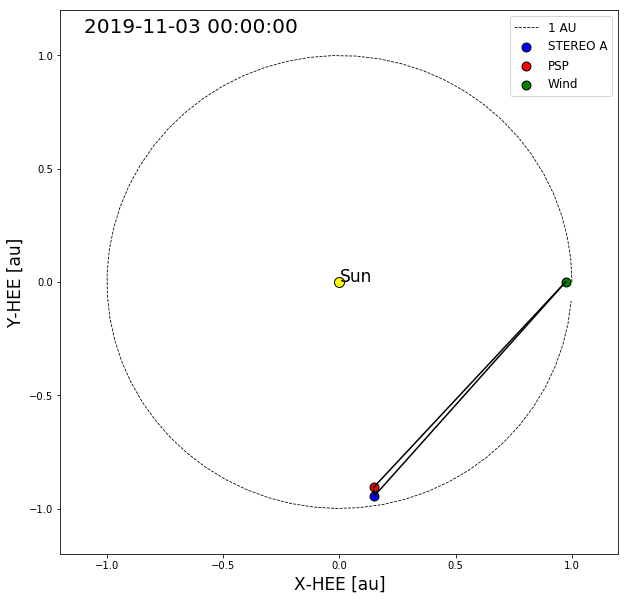

In [9]:
L_mult = 1- ((const.M_earth.value/(const.M_earth.value+const.M_sun.value))/3)**(1/3) # L1 point ratio

Ax,Bx,Wx = [body.x.value for body in bodies]
Ay,By,Wy = [body.y.value for body in bodies]
Wx *= L_mult
Wy *= L_mult

# Setup Figure
fig,ax = plt.subplots(figsize=(10,10))
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])
ax.set_xlabel(f"X-{SPICE_Frame} [{units}]",fontsize=17)
ax.set_ylabel(f"Y-{SPICE_Frame} [{units}]",fontsize=17)

sol = ax.scatter(0,0,marker='o',color="yellow",s=100,edgecolors='black')
sol_txt = plt.text(0,0,"Sun",fontsize=17)

AB = ax.plot([Ax[0],Bx[0]],[Ay[0],By[0]],color="black")[0]
AW = ax.plot([Ax[0],Wx[0]],[Ay[0],Wy[0]],color="black")[0]
BW = ax.plot([Bx[0],Wx[0]],[By[0],Wy[0]],color="black")[0]

#A_orb = ax.plot(Ax,Ay,linestyle = ":",color="black",alpha=0.5,linewidth=0.5)
#B_orb = ax.plot(Bx,By,linestyle = ":",color="black",alpha=0.5,linewidth=0.5)
#W_orb = ax.plot(Wx,Wy,linestyle = ":",color="black",alpha=0.5,linewidth=0.5)
angle=np.arange(0,2*np.pi,0.1)
ONE_AU = ax.plot(np.cos(angle),np.sin(angle),color="black",linewidth=0.8,linestyle="--",label="1 AU")

A = ax.scatter(Ax[0],Ay[0],color="blue",s=80,label="STEREO A",edgecolors='black')
B = ax.scatter(Bx[0],By[0],color="red",s=80,label="PSP",edgecolors='black')
W = ax.scatter(Wx[0],Wy[0],color="green",s=80,label="Wind",edgecolors='black')

texts = [ax.text(-1.1,1.1,f"{times[0]}",fontsize=20)]

legend = plt.legend(fontsize=12,loc=1)


def plot_constellation(ii) :
    AB.set_data([Ax[ii],Bx[ii]],[Ay[ii],By[ii]])
    AW.set_data([Ax[ii],Wx[ii]],[Ay[ii],Wy[ii]])
    BW.set_data([Bx[ii],Wx[ii]],[By[ii],Wy[ii]])
    A.set_offsets([Ax[ii],Ay[ii]])
    B.set_offsets([Bx[ii],By[ii]])
    W.set_offsets([Wx[ii],Wy[ii]])
    texts[0].set_text(f"{times[ii]}")
    return [AB,AW,BW,A,B,W]

date_time = datetime(2019,11,3)
ii = np.where(np.array(times) >= date_time)[0][0]
AB,AW,BW,A,B,W=plot_constellation(ii)

In [8]:
fname="AWP_Constellation_HEE.mp4"
fps = 24
anim = animation.FuncAnimation(fig,plot_constellation,frames=len(times)-1,blit=True)
anim.save(fname,fps=fps)

In [24]:
SPICE_Origin = 'Venus'
SPICE_Frame = 'HEE'#'ECLIPJ2000'
t_start=(2018, 10, 1) 
t_final=(2024, 11, 30)
t_delta=1./24
units = 'au'
body_list = ['Venus','SPP', 'Earth']
# Generate Heliopy Spice Body Objects
bodies = [spice.Trajectory(body) for body in body_list]

# Generate Time Series to Plot Orbits Over
starttime = datetime(*t_start) 
endtime = datetime(*t_final) 
times = []
while starttime < endtime:
    times.append(starttime)
    starttime += timedelta(days=t_delta)

unit_dict = {'m' : u.m, 'R_earth' : u.R_earth, 'R_sun' : u.R_sun, 'au' : u.au}    

# Generate Positions for each body over the specified times
reference = SPICE_Origin
frame = SPICE_Frame
spice_error_inds = [] 
for body,index in zip(bodies,range(len(bodies))) :
    try : # If no or partial spice data for a given body in the timeframe, remove from plot
        body.generate_positions(times, reference, frame)
        body.change_units(unit_dict.get(units))
    except :
        print(f"Some/All SPICE data missing for {body.target} in time range {t_start} to {t_final}")
        print(f"Omitting {body.target}")
        spice_error_inds.append(index-len(spice_error_inds))
if len(spice_error_inds) > 0 :
    for ind in spice_error_inds : bodies.pop(ind)        
    print(f"Remaining bodies in list : {[body_.target for body_ in bodies]}")
    

Text(0.5, 0, 'Time/ Year')

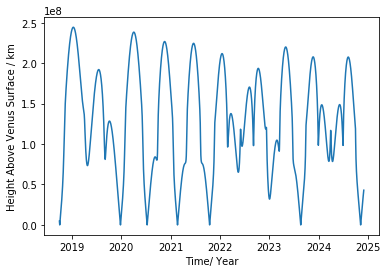

In [32]:
plt.plot(times,bodies[1].r.to('km').value-6000)
plt.ylabel("Height Above Venus Surface / km")
plt.xlabel("Time/ Year")
#plt.yscale('log')

In [31]:
np.min(bodies[1].r.to('km').value-6000)

4193.778714216805